<a href="https://colab.research.google.com/github/varaah/analisis-sentimen-ikn/blob/main/01.%20Wilton%20Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training Multiclass Classification Model with Wilton Park Archives**

In this notebook, we will conduct training for multicass classificication model using Wilton Park archives as the training data. We will train the model in three different combinations of feature extraction methods and training algorithms:

* Model I: Logistic Regression with TF-IDF
* Model II: Support Vector Machine with TF-IDF
* Model III: Logistic Regression with Doc2Vec

We will then evaluate each model to see which model perform the best.



# 1 | Preparation

We first install libraries needed to extract text data from the archives. For this purpose, we use `pdfplumber` for pdf text extraction and `python-docx` to extract text from docx files.

In [ ]:
# Install libraries to extract text from pdf and docx files
!pip install pdfplumber
!pip install python-docx
!pip install testfixtures

We also configure the notebook to display text in wrapped view for better viewing of the text output.

In [ ]:
# Setting output text to wrapped
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

We then import required libraries and set the parameters.

In [ ]:
# Importing libraries
import os
import re
import pickle
import joblib
import subprocess
import pdfplumber
import docx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Mounting gdrive to colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Setting parameter
min_characters_para = 300   # Min characters in a paragraph (inclusive)
min_characters_word = 3     # Min characters in a word (inclusive)
test_size = 0.2     # Fraction of corpus to keep back for testing

# 2 | Data Extraction and Exploration

For easier use, we build a function for extracting text document from pdf and word documents. For easier handling of word documents, we will convert any `.doc` file into `.docx` before performing text extraction.

## Text Extraction Functions

We first build a function to extract the information of files within the folder, and then we build a function to extract text from each document. 

**Function for extracting filenames:**

In [ ]:
# Function for extracting file and folder names from drive
def extractFilenames(dirpath):
  """Returns a dataframe with extracted file path and folder names.
  Folder structure is two layers down (dirpath - folders - files).
  For Ditchley archive, it's recommended to use decades folder (e.g. 1960s)."""
   
  # Extracting filenames and folder names (as theme)
  filenames = []

  for dirname in os.listdir(dirpath):
    subdir = os.path.join(dirpath, dirname)
    # Checking if it is a folder
    if os.path.isdir(subdir):
      for filename in os.listdir(subdir):
        f = os.path.join(subdir, filename)
    
        # Checking if it is a file
        if os.path.isfile(f):
          filenames.append([f, dirname, filename])
  
  df_files = pd.DataFrame(filenames, columns=['file_path', 'folder_names', 'file_names'])
  df_files = df_files.sort_values(by=['folder_names', 'file_names'], ascending=True).reset_index(drop=True)

  return df_files

In [ ]:
# Use example for Wilton Park
# url_wilton = "gdrive/MyDrive/Corpus/Wilton Park/"
# file_wilton = extractFilenames(url_wilton)
# file_wilton.head()

In [ ]:
# # Use example for Ditchley
# url_ditchley = "gdrive/MyDrive/Digital Archive - Director's Notes/Digital Archive - Director's Notes/1990s/"
# file_ditchley = extractFilenames(url_ditchley)
# file_ditchley

**Function for extracting text from documents:**

As the documents are in pdf and docx format, we configure the function to accommodate the different formats.

In [ ]:
# Function for extracting file and folder names from drive
def extractText(df_files):
  """Returns a dataframe with extracted text from documents.
  It takes a df from extractFilenames() function as the input,
  then loop over the row to extract the text from each document."""

  # Loop over the each file and extract the text
  text_corpus = pd.DataFrame()

  for i in range(0, len(df_files['file_path'])):
    path = df_files['file_path'][i]
    folder_names = df_files['folder_names'][i]
    filenames = path.split(os.sep)[-1]
    
    # Extracting pdf document
    if path.endswith('.pdf'):
      final_text = []

      with pdfplumber.open(path) as pdf:
        full_pages = ''
        for page in pdf.pages:
          single_page = page.extract_text()
          # Separating each page's text with newline
          full_pages = full_pages + '\n' + single_page
    
        # Clean white space for easier paragraph identification
        full_pages = re.sub("/^\s+|\s+$|\s+(?=\s)", "", full_pages)
        
        # Identify paragraph and add separator
        full_pages = re.sub(r'(?:\.)(?:\n)([A-Z])', r".<par>\1", full_pages) # Start of paragraph
        full_pages = re.sub(r'((\s(\d{1,2}\.)\s)|([VIX]+\.\s)|(\•\s))', r"<par>\1", full_pages) # Bullet points
    
        # Split page into paragraphs
        page_split = re.split("<par>", str(full_pages))

      # Only retain paragraphs with at least N characters to retain only proper paragraphs
      for paragraph in page_split:
        if len(paragraph) >= min_characters_para:
          final_text.append(paragraph)

    # Extracting docx document
    elif path.endswith('.docx') and not filenames.startswith('~'):
      final_text = []

      full_text = []
      doc = docx.Document(path)
      
      for para in doc.paragraphs:
        full_text.append(para.text)
      
      # Only retain paragraphs with at least N characters to retain only proper paragraphs
      for paragraph in full_text:
        if len(paragraph) >= min_characters_para:
          final_text.append(paragraph)
      
    # Append paragraphs to final corpus
    for paragraph in final_text:
      text_corpus = text_corpus.append({'text' : paragraph, 'folder_names' : folder_names, 'filenames' : filenames}, ignore_index=True)
  
  return text_corpus

## Extract Training Data - Wilton Park

We run the text extraction functions to collect text data from the Wilton Park archive to be used as our preliminary training data. The Wilton Park archives have seven major themes that we use as our labels. These themes are:
* Conflict prevention, resolution and state building
* Multilateral institutions, key countries and regions
* Global health
* Global economy
* Sustainable development and the environment
* Defence and security
* Human rights, good governance and faith

In [ ]:
# Setting dir path
directory = "gdrive/MyDrive/Corpus/Wilton Park/"

# Extract filenames
df_files = extractFilenames(directory)

# Extract training corpus
training_corpus = extractText(df_files)

## Exploratory Data Analysis (EDA)


In [ ]:
# Conserve the raw text
training_corpus['raw'] = training_corpus['text']

# Rename column names
training_corpus.rename(columns={"folder_names": "themes"}, inplace=True)
training_corpus.head()

,text,themes,filenames,raw
0,"Report\nCultural Heritage Protection, Develop...","conflict prevention, resolution and state buil...",WP1877V1-Report.pdf,"Report\nCultural Heritage Protection, Develop..."
1,With economies and geographies being rapidly r...,"conflict prevention, resolution and state buil...",WP1877V1-Report.pdf,With economies and geographies being rapidly r...
2,\n5. While recognising significant challenges ...,"conflict prevention, resolution and state buil...",WP1877V1-Report.pdf,\n5. While recognising significant challenges ...
3,This Wilton Park virtual dialogue aimed to:\n▪...,"conflict prevention, resolution and state buil...",WP1877V1-Report.pdf,This Wilton Park virtual dialogue aimed to:\n▪...
4,Intended outcomes for this Wilton Park virtual...,"conflict prevention, resolution and state buil...",WP1877V1-Report.pdf,Intended outcomes for this Wilton Park virtual...


In [ ]:
training_corpus.shape

(714, 4)

In [ ]:
training_corpus.groupby(['themes'])['themes'].count()

themes
conflict prevention, resolution and state building       96
defence and security                                    105
global economy                                          100
global health                                            99
human rights, good governance and faith                 112
multilateral institutions, key countries and regions     99
sustainable development and the environment             103
Name: themes, dtype: int64

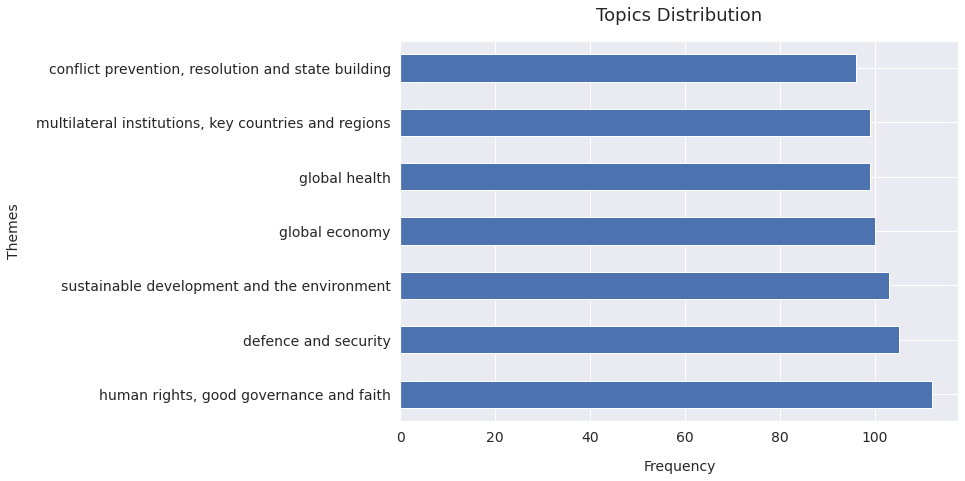

In [ ]:
# Visualise the training corpus
sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(10, 7))
training_corpus['themes'].value_counts().plot.barh()

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title("Topics Distribution", pad=20, fontsize=18)
plt.xlabel("Frequency", labelpad=15, fontsize=14)
plt.ylabel("Themes", labelpad=15, fontsize=14)
plt.show()

In [ ]:
# Save training dataset
training_corpus.to_csv("gdrive/MyDrive/Colab Notebooks/models/v1.3-wilton/output/wilton_corpus.csv", index=False)

# 3 | Pre-processing

In pre-processing stage, we perform several text cleansing methods, including tokenisation, standardisation and cleaning, stopwords removal, and lemmatisation.

In [ ]:
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))

def cleanText(text):
  # Keep only words
  text = re.sub("[^a-zA-Z]", " ", text)

  # Convert to lower case and split
  text = text.lower().split()

  # Remove stopwords
  tokens = []
  for word in text:
    if (len(word) >= min_characters_word) & (word not in stop_words) : tokens.append(word)

  # Lemmatise words
  lm = WordNetLemmatizer()
  stemmed_words = [lm.lemmatize(w) for w in tokens]

  # Join the cleaned words
  cleaned_text = " ".join(stemmed_words)

  return cleaned_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Remove '\n' in the new dataset
def removeNewLine(text):
  text = re.sub("\n", " ", text)
  return text

In [ ]:
# Apply text cleaning
training_corpus['text'] = training_corpus['text'].apply(cleanText)

#training_corpus.head()

In [ ]:
training_corpus

,text,themes,filenames,raw
0,report cultural heritage protection developmen...,"conflict prevention, resolution and state buil...",WP1877V1-Report.pdf,"Report\nCultural Heritage Protection, Develop..."
1,economy geography rapidly reshaped covid crisi...,"conflict prevention, resolution and state buil...",WP1877V1-Report.pdf,With economies and geographies being rapidly r...
2,recognising significant challenge promoting in...,"conflict prevention, resolution and state buil...",WP1877V1-Report.pdf,\n5. While recognising significant challenges ...
3,wilton park virtual dialogue aimed convene fac...,"conflict prevention, resolution and state buil...",WP1877V1-Report.pdf,This Wilton Park virtual dialogue aimed to:\n▪...
4,intended outcome wilton park virtual dialogue ...,"conflict prevention, resolution and state buil...",WP1877V1-Report.pdf,Intended outcomes for this Wilton Park virtual...
...,...,...,...,...
709,grounding conversation political reality intro...,sustainable development and the environment,WP2026-Report.pdf,Grounding the conversation in the political re...
710,dialogue second series three designed bring to...,sustainable development and the environment,WP2026-Report.pdf,• This dialogue was the second in a series of ...
711,time third dialogue planned september governme...,sustainable development and the environment,WP2026-Report.pdf,"• By the time of the third dialogue, which is ..."
712,interim wilton park host smaller convening sum...,sustainable development and the environment,WP2026-Report.pdf,"• In the interim, Wilton Park will host a smal..."


In [ ]:
# Save cleaned training dataset
training_corpus.to_csv("gdrive/MyDrive/Colab Notebooks/models/v1.3-wilton/output/wilton_corpus_cleaned.csv", index=False)

**Example of preprocessing steps for schematic:**

In [ ]:
text = '16. There was a commitment amongst participants to continue these conversations, enhance connections, and advocate for the value of cultural heritage protection within the global agenda.'

# lowercase conversion
text = text.lower()
print(text)

# Noise removal
text = re.sub("[^a-zA-Z]", " ", text).strip()
print(text)

text = text.split()

# Remove stopwords
tokens = []
for word in text:
  if (len(word) >= min_characters_word) & (word not in stop_words) : tokens.append(word)

print(" ".join(tokens))

# Lemmatise words
lm = WordNetLemmatizer()
stemmed_words = [lm.lemmatize(w) for w in tokens]

print(" ".join(stemmed_words))

16. there was a commitment amongst participants to continue these conversations, enhance connections, and advocate for the value of cultural heritage protection within the global agenda.
there was a commitment amongst participants to continue these conversations  enhance connections  and advocate for the value of cultural heritage protection within the global agenda
commitment amongst participants continue conversations enhance connections advocate value cultural heritage protection within global agenda
commitment amongst participant continue conversation enhance connection advocate value cultural heritage protection within global agenda


# 4 | Feature Engineering

## Text Representation

For each term in the dataset, we calculate a measure called "Term Frequency, Inverse Document Frequency", abbreviated to `tf-idf`. We will use `sklearn.feature_extraction.text.TfidfVectorizer` to calculate a tf-idf vector for each row of text.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf= True,
                       min_df = 5,
                       norm = 'l2',
                       ngram_range = (1,2),
                       stop_words ='english')

features = tfidf.fit_transform(training_corpus.text).toarray()
labels = training_corpus.themes

features.shape

(714, 1715)

Each of 725 text is represented by 1,744 features, representing the tf-idf score for different unigrams and bigrams.

We can also see the terms that are the most correlated with each themes:

In [ ]:
from sklearn.feature_selection import chi2

N = 2

for theme in training_corpus.themes.unique():
  features_chi2 = chi2(features, labels == theme)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# Theme: '{}':".format(theme))
  print("  . Most correlated unigrams:\n    . {}".format('\n    . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n    . {}".format('\n    . '.join(bigrams[-N:])))
  print()

# Theme: 'conflict prevention, resolution and state building':
  . Most correlated unigrams:
    . reconstruction
    . heritage
  . Most correlated bigrams:
    . heritage protection
    . cultural heritage

# Theme: 'defence and security':
  . Most correlated unigrams:
    . cyber
    . cyberspace
  . Most correlated bigrams:
    . operation cyberspace
    . military operation

# Theme: 'global economy':
  . Most correlated unigrams:
    . men
    . woman
  . Most correlated bigrams:
    . men woman
    . listening series

# Theme: 'global health':
  . Most correlated unigrams:
    . healthy
    . health
  . Most correlated bigrams:
    . global health
    . healthy society

# Theme: 'human rights, good governance and faith':
  . Most correlated unigrams:
    . education
    . vawg
  . Most correlated bigrams:
    . tertiary education
    . higher education

# Theme: 'multilateral institutions, key countries and regions':
  . Most correlated unigrams:
    . asean
    . rule
  . Most 

## Splitting Dataset & Vectorisation

Before training the model, we split the dataset into training and testing dataset. The proportion of training and testing split is 80:20.

To train supervised classifiers, we also need to transform the text into a vector of numbers. In this section of the project, we explore `TF-IDF` weighted vectors as our vector representations method.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

# Split the dataset
X = training_corpus['text']
y = training_corpus['themes']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = test_size,
                                                    random_state = 2)

# Vectorize the dataset
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_transformed = tf_transformer.transform(X_train_counts)

X_test_counts = count_vect.transform(X_test)
X_test_transformed = tf_transformer.transform(X_test_counts)

In [ ]:
# Save TF-IDF vectoriser
joblib.dump(count_vect, "gdrive/MyDrive/Colab Notebooks/models/v1.3-wilton/output/tf_countvect.pkl")
joblib.dump(tf_transformer, "gdrive/MyDrive/Colab Notebooks/models/v1.3-wilton/output/tf_transformer.pkl")

['gdrive/MyDrive/Colab Notebooks/models/v1.3-wilton/output/tf_transformer.pkl']

# 5 | Model I: Logistic Regression - TF-IDF

## Model Training

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state = 123)
lr.fit(X_train_transformed, y_train)

y_pred_lr = lr.predict(X_test_transformed)

## Model Evaluation

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

def heatconmat(y_true,y_pred):
  sns.set_context('talk')
  plt.figure(figsize=(9,6))
  sns.heatmap(confusion_matrix(y_true,y_pred),
              annot=True,
              fmt='d',
              cbar=False,
              cmap='gist_earth_r',
              yticklabels=sorted(y_true.unique()))
  plt.show()
  print()
  print()
  print(classification_report(y_true,y_pred))

**Evaluation metrics:**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred_lr))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred_lr, average='weighted')))

Testing accuracy 0.9440559440559441
Testing F1 score: 0.9437335307534257


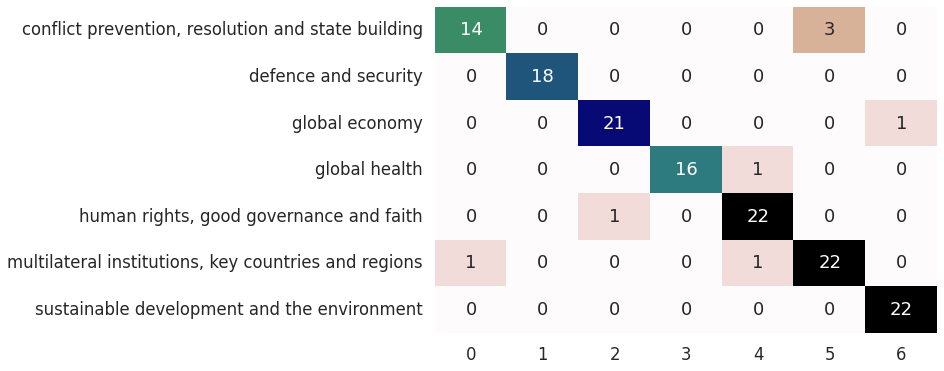



                                                      precision    recall  f1-score   support

  conflict prevention, resolution and state building       0.93      0.82      0.87        17
                                defence and security       1.00      1.00      1.00        18
                                      global economy       0.95      0.95      0.95        22
                                       global health       1.00      0.94      0.97        17
             human rights, good governance and faith       0.92      0.96      0.94        23
multilateral institutions, key countries and regions       0.88      0.92      0.90        24
         sustainable development and the environment       0.96      1.00      0.98        22

                                            accuracy                           0.94       143
                                           macro avg       0.95      0.94      0.94       143
                                        weighted avg    

In [ ]:
heatconmat(y_test, y_pred_lr)

In [ ]:
# Saving the model using joblib
filename_m1 = "gdrive/MyDrive/Colab Notebooks/models/v1.3-wilton/output/lr_tfidf_model.sav"  
joblib.dump(lr, filename_m1)

['gdrive/MyDrive/Colab Notebooks/models/v1.3-wilton/output/lr_tfidf_model.sav']

**Distribution of prediction for each theme:**

To better understand the model, we also visualise the distribution of prediction for each themes.

In [ ]:
# Class names from the prediction
class_names = list(lr.classes_)

# Create training result dataframe
train_y_pred_lr = pd.DataFrame(y_pred_lr, columns = ['prediction'])
train_x_test_lr = pd.DataFrame(X_test, columns = ['text'])
train_y_test_lr = pd.DataFrame(y_test, columns = ['themes'])

train_idx_lr = train_x_test_lr.index # Preserve index
train_x_test_lr.reset_index(drop=True, inplace=True) # Reset index to concat
train_y_test_lr.reset_index(drop=True, inplace=True)

# Retrieve raw text
raw_lr = []

for i in train_idx_lr:
  raw_lr.append(training_corpus.iloc[i]['raw'])

train_raw_lr = pd.DataFrame(raw_lr, columns = ['raw'])['raw'].apply(removeNewLine)

# Concat all columns
train_result_lr = pd.concat([train_raw_lr, train_y_test_lr, train_y_pred_lr], axis = 1)
train_result_lr = train_result_lr.set_index(train_idx_lr)
#train_result_lr.head()

Theme 1: conflict prevention, resolution and state building

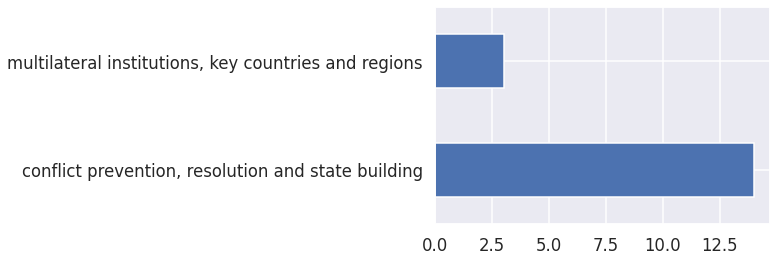

In [ ]:
# Theme 1: conflict prevention, resolution and state building
train_sel_t1_lr = train_result_lr['themes'] == "conflict prevention, resolution and state building"
train_t1_lr = train_result_lr[train_sel_t1_lr]
train_t1_lr.value_counts()
train_t1_lr['prediction'].value_counts().plot.barh()

Theme 2: defence and security

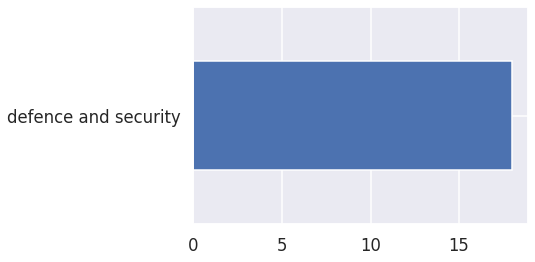

In [ ]:
# Theme 2: defence and security
train_sel_t2_lr = train_result_lr['themes'] == "defence and security"
train_t2_lr = train_result_lr[train_sel_t2_lr]
train_t2_lr.value_counts()
train_t2_lr['prediction'].value_counts().plot.barh()

Theme 3: global economy

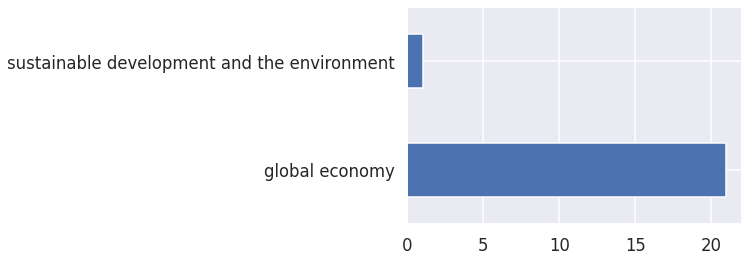

In [ ]:
# Theme 3: global economy
train_sel_t3_lr = train_result_lr['themes'] == "global economy"
train_t3_lr = train_result_lr[train_sel_t3_lr]
train_t3_lr.value_counts()
train_t3_lr['prediction'].value_counts().plot.barh()

Theme 4: global health

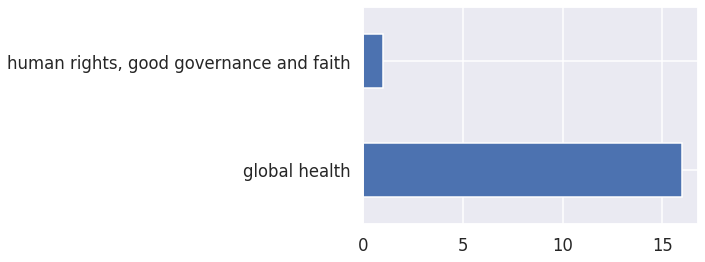

In [ ]:
# Theme 4: global health
train_sel_t4_lr = train_result_lr['themes'] == "global health"
train_t4_lr = train_result_lr[train_sel_t4_lr]
train_t4_lr.value_counts()
train_t4_lr['prediction'].value_counts().plot.barh()

Theme 5: human rights, good governance and faith

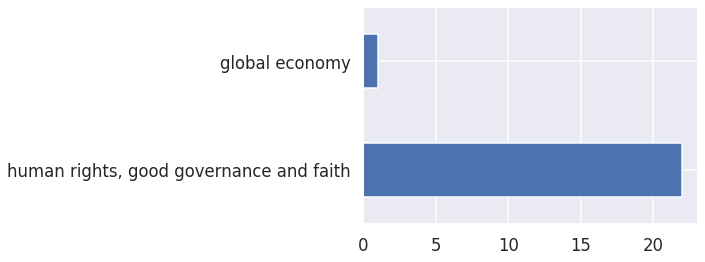

In [ ]:
# Theme 5: human rights, good governance and faith
train_sel_t5_lr = train_result_lr['themes'] == "human rights, good governance and faith"
train_t5_lr = train_result_lr[train_sel_t5_lr]
train_t5_lr.value_counts()
train_t5_lr['prediction'].value_counts().plot.barh()

Theme 6: multilateral institutions, key countries and regions

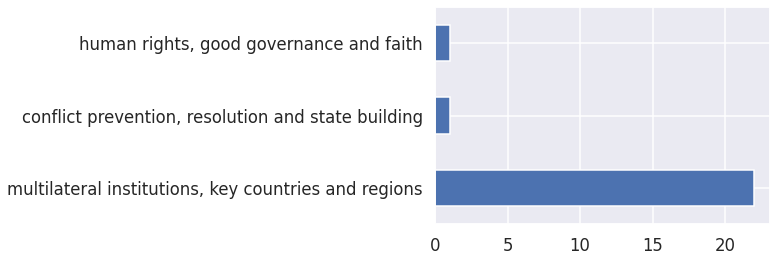

In [ ]:
# Theme 6: multilateral institutions, key countries and regions
train_sel_t6_lr = train_result_lr['themes'] == "multilateral institutions, key countries and regions"
train_t6_lr = train_result_lr[train_sel_t6_lr]
train_t6_lr.value_counts()
train_t6_lr['prediction'].value_counts().plot.barh()

Theme 7: sustainable development and the environment

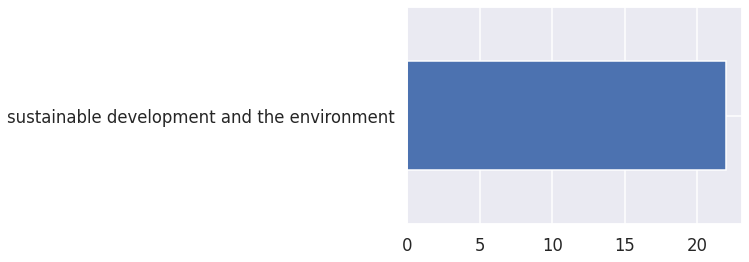

In [ ]:
# Theme 7: sustainable development and the environment
train_sel_t7_lr = train_result_lr['themes'] == "sustainable development and the environment"
train_t7_lr = train_result_lr[train_sel_t7_lr]
train_t7_lr.value_counts()
train_t7_lr['prediction'].value_counts().plot.barh()

**Predictions that are different from labeled themes:**

In [ ]:
# Sample of predictions that are different from labeled themes
train_lr_false_pred = train_result_lr[train_result_lr.themes != train_result_lr.prediction]
display(train_lr_false_pred)

,raw,themes,prediction
62,6. Although there are many drivers of conflic...,"conflict prevention, resolution and state buil...","multilateral institutions, key countries and r..."
221,Politicians frequently refer to climate change...,global economy,sustainable development and the environment
445,45. Association of Women in Development (www....,"human rights, good governance and faith",global economy
520,8. The post-World War II global order was est...,"multilateral institutions, key countries and r...","conflict prevention, resolution and state buil..."
84,26. Great powers will remain central to world...,"conflict prevention, resolution and state buil...","multilateral institutions, key countries and r..."
55,New policy development should be based on regi...,"conflict prevention, resolution and state buil...","multilateral institutions, key countries and r..."
583,"33. We need to create a new social contract, ...","multilateral institutions, key countries and r...","human rights, good governance and faith"
340,Hannah Ryder: hannahryder@developmentreimagine...,global health,"human rights, good governance and faith"


## Prediction on New Data - Wilton Park

**Loading new unseen dataset:**

In [ ]:
# Setting root path
directory_test = 'gdrive/MyDrive/Corpus/Test/'

# Extract filenames
df_testing = extractFilenames(directory_test)

# Extract testing corpus
testing_corpus = extractText(df_testing)

In [ ]:
# Conserve the raw text
testing_corpus['raw'] = testing_corpus['text']

# Rename column names
testing_corpus.rename(columns={"folder_names": "themes"}, inplace=True)

# Apply text cleaning
testing_corpus['text'] = testing_corpus['text'].apply(cleanText)
testing_corpus['raw'] = testing_corpus['raw'].apply(removeNewLine)

print(testing_corpus.shape)
testing_corpus.head()

(156, 4)


,text,themes,filenames,raw
0,report adapting deterrence strategy changing s...,defence and security,defence and security-WP1610-Report.pdf,report adapting deterrence strategy changing s...
1,nato committed ensuring deterrence posture wou...,defence and security,defence and security-WP1610-Report.pdf,nato committed ensuring deterrence posture wou...
2,period since beginning wale summit nato streng...,defence and security,defence and security-WP1610-Report.pdf,period since beginning wale summit nato streng...
3,additional question introduced trump administr...,defence and security,defence and security-WP1610-Report.pdf,additional question introduced trump administr...
4,facing new question nato member must come term...,defence and security,defence and security-WP1610-Report.pdf,facing new question nato member must come term...


**Prediction Result:**

In [ ]:
# Model prediction
y_pred_lr_test = lr.predict(tf_transformer.transform(count_vect.transform(testing_corpus['text'])))

# Add prediction result to the testing_corpus
testing_corpus['predicted_lr'] = y_pred_lr_test

# Count accuracy
accuracy = sum(1 for x, y in zip(testing_corpus['themes'], testing_corpus['predicted_lr']) if x == y) / float(len(testing_corpus['themes']))
print('Accuracy: ', str(accuracy))

Accuracy:  0.8653846153846154


**Distribution of prediction for each theme:**

Theme 1: defence and security

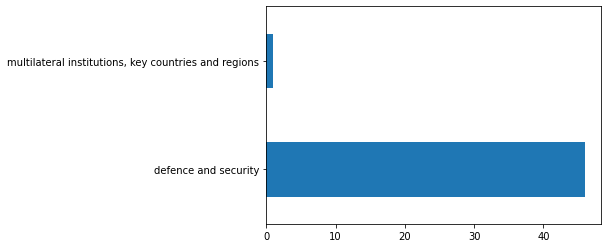

In [ ]:
# Theme 1: defence and security
test_sel_t1_lr = testing_corpus['themes'] == "defence and security"
test_t1_lr = testing_corpus[test_sel_t1_lr]
test_t1_lr.value_counts()
test_t1_lr['predicted_lr'].value_counts().plot.barh()

Theme 2: global health

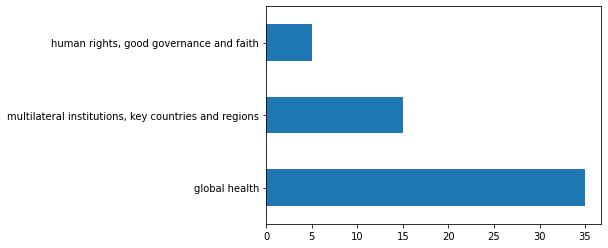

In [ ]:
# Theme 2: global health
test_sel_t2_lr = testing_corpus['themes'] == "global health"
test_t2_lr = testing_corpus[test_sel_t2_lr]
test_t2_lr.value_counts()
test_t2_lr['predicted_lr'].value_counts().plot.barh()

Theme 3: human rights, good governance and faith

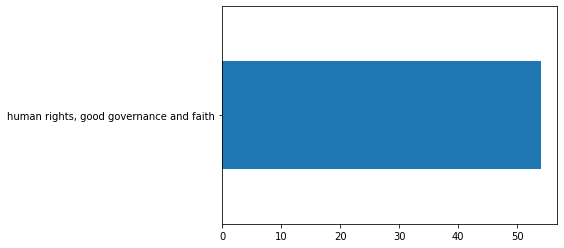

In [ ]:
# Theme 3: human rights, good governance and faith
test_sel_t3_lr = testing_corpus['themes'] == "human rights, good governance and faith"
test_t3_lr = testing_corpus[test_sel_t3_lr]
test_t3_lr.value_counts()
test_t3_lr['predicted_lr'].value_counts().plot.barh()

**Predictions that are different from labeled themes:**

In [ ]:
# Predictions that are different from labeled themes
display(testing_corpus[testing_corpus['themes'] != testing_corpus['predicted_lr']][['raw', 'themes', 'predicted_lr']])

,raw,themes,predicted_lr
33,although many country seek remain close grow c...,defence and security,"multilateral institutions, key countries and r..."
52,proposed dhl program take modular blended lear...,global health,"human rights, good governance and faith"
53,leadership development team individual encoura...,global health,"multilateral institutions, key countries and r..."
56,certification including award badging form rec...,global health,"human rights, good governance and faith"
58,dhl program need robust governance management ...,global health,"multilateral institutions, key countries and r..."
62,potential next step commitment interest contin...,global health,"multilateral institutions, key countries and r..."
65,draft strategy go say whilst need vary region ...,global health,"multilateral institutions, key countries and r..."
66,dhl program presented participant wilton park ...,global health,"multilateral institutions, key countries and r..."
73,need competency framework dhl program addition...,global health,"human rights, good governance and faith"
74,matter reliable connectivity viability remote ...,global health,"multilateral institutions, key countries and r..."


# 6 | Model II: Support Vector Machine - TF-IDF

## Model Training

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

svc = LinearSVC(random_state=123)
svc_cal = CalibratedClassifierCV(svc)
svc_cal.fit(X_train_transformed, y_train)

y_pred_svc = svc_cal.predict(X_test_transformed)

## Model Evaluation

**Evaluation metrics:**

In [ ]:
# Evaluation metric
print('Testing accuracy %s' % accuracy_score(y_test, y_pred_svc))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred_svc, average='weighted')))

Testing accuracy 0.965034965034965
Testing F1 score: 0.964857923078426


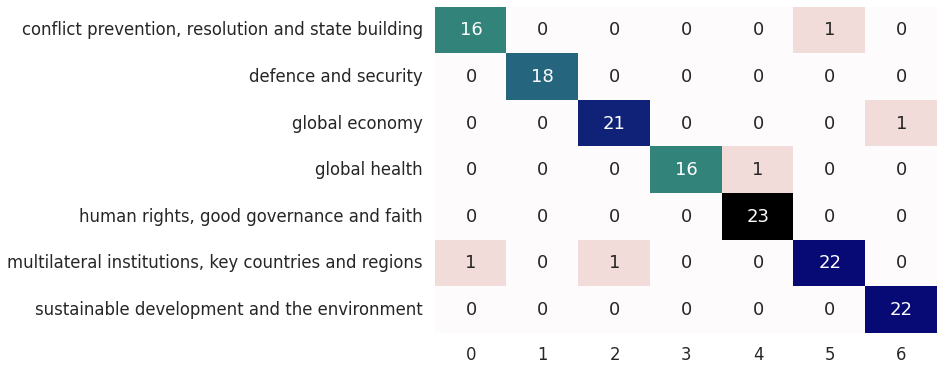



                                                      precision    recall  f1-score   support

  conflict prevention, resolution and state building       0.94      0.94      0.94        17
                                defence and security       1.00      1.00      1.00        18
                                      global economy       0.95      0.95      0.95        22
                                       global health       1.00      0.94      0.97        17
             human rights, good governance and faith       0.96      1.00      0.98        23
multilateral institutions, key countries and regions       0.96      0.92      0.94        24
         sustainable development and the environment       0.96      1.00      0.98        22

                                            accuracy                           0.97       143
                                           macro avg       0.97      0.96      0.97       143
                                        weighted avg    

In [ ]:
heatconmat(y_test, y_pred_svc)

In [ ]:
# Saving the model using joblib
filename_m2 = "gdrive/MyDrive/Colab Notebooks/models/v1.3-wilton/output/svc_tfidf_model.sav"  
joblib.dump(svc_cal, filename_m2)

['gdrive/MyDrive/Colab Notebooks/models/v1.3-wilton/output/svc_tfidf_model.sav']

**Distribution of prediction for each theme:**

To better understand the model, we also visualise the distribution of prediction for each themes.

In [ ]:
# Class names from the prediction
class_names = list(svc_cal.classes_)

# Create training result dataframe
train_y_pred_svc = pd.DataFrame(y_pred_svc, columns = ['prediction'])
train_x_test_svc = pd.DataFrame(X_test, columns = ['text'])
train_y_test_svc = pd.DataFrame(y_test, columns = ['themes'])

train_idx_svc = train_x_test_svc.index # Preserve index
train_x_test_svc.reset_index(drop=True, inplace=True) # Reset index to concat
train_y_test_svc.reset_index(drop=True, inplace=True)

# Retrieve raw text
raw_svc = []

for i in train_idx_svc:
  raw_svc.append(training_corpus.iloc[i]['raw'])

train_raw_svc = pd.DataFrame(raw_svc, columns = ['raw'])['raw'].apply(removeNewLine)

# Concat all columns
result_train_svc = pd.concat([train_raw_svc, train_y_test_svc, train_y_pred_svc], axis = 1)
result_train_svc = result_train_svc.set_index(train_idx_svc)
#result_train_svc.head()

Theme 1: conflict prevention, resolution and state building

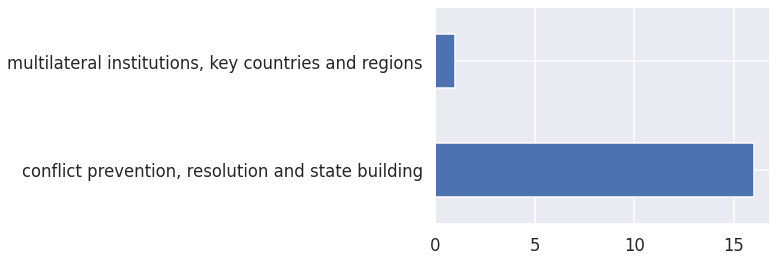

In [ ]:
# Theme 1: conflict prevention, resolution and state building
train_sel_t1_svc = result_train_svc['themes'] == "conflict prevention, resolution and state building"
train_t1_svc = result_train_svc[train_sel_t1_svc]
train_t1_svc.value_counts()
train_t1_svc['prediction'].value_counts().plot.barh()

Theme 2: defence and security

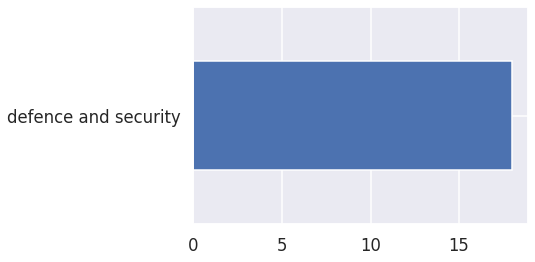

In [ ]:
# Theme 2: defence and security
train_sel_t2_svc = result_train_svc['themes'] == "defence and security"
train_t2_svc = result_train_svc[train_sel_t2_svc]
train_t2_svc.value_counts()
train_t2_svc['prediction'].value_counts().plot.barh()

Theme 3: global economy

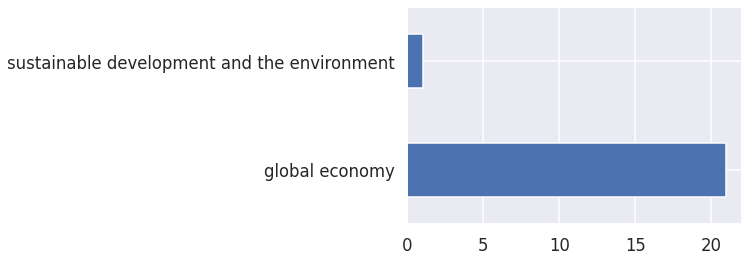

In [ ]:
# Theme 3: global economy
train_sel_t3_svc = result_train_svc['themes'] == "global economy"
train_t3_svc = result_train_svc[train_sel_t3_svc]
train_t3_svc.value_counts()
train_t3_svc['prediction'].value_counts().plot.barh()

Theme 4: global health

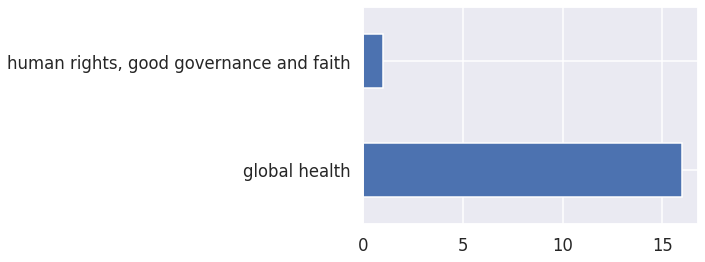

In [ ]:
# Theme 4: global health
train_sel_t4_svc = result_train_svc['themes'] == "global health"
train_t4_svc = result_train_svc[train_sel_t4_svc]
train_t4_svc.value_counts()
train_t4_svc['prediction'].value_counts().plot.barh()

Theme 5: human rights, good governance and faith

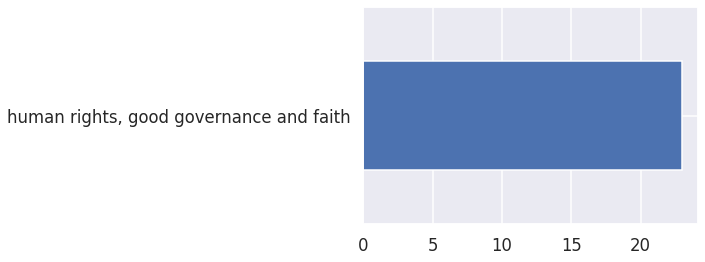

In [ ]:
# Theme 5: human rights, good governance and faith
train_sel_t5_svc = result_train_svc['themes'] == "human rights, good governance and faith"
train_t5_svc = result_train_svc[train_sel_t5_svc]
train_t5_svc.value_counts()
train_t5_svc['prediction'].value_counts().plot.barh()

Theme 6: multilateral institutions, key countries and regions

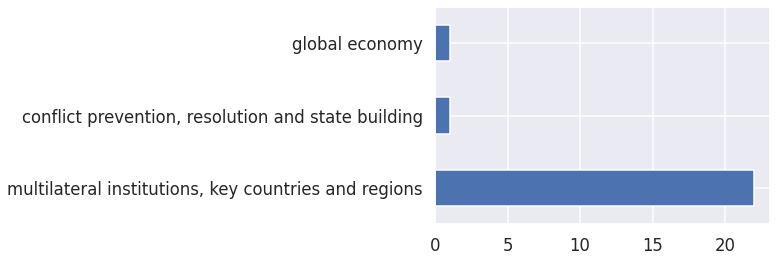

In [ ]:
# Theme 6: multilateral institutions, key countries and regions
train_sel_t6_svc = result_train_svc['themes'] == "multilateral institutions, key countries and regions"
train_t6_svc = result_train_svc[train_sel_t6_svc]
train_t6_svc.value_counts()
train_t6_svc['prediction'].value_counts().plot.barh()

Theme 7: sustainable development and the environment

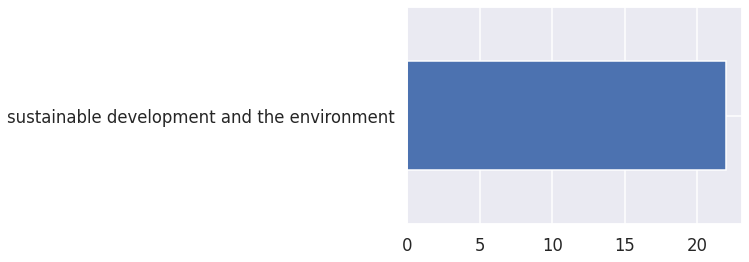

In [ ]:
# Theme 7: sustainable development and the environment
train_sel_t7_svc = result_train_svc['themes'] == "sustainable development and the environment"
train_t7_svc = result_train_svc[train_sel_t7_svc]
train_t7_svc.value_counts()
train_t7_svc['prediction'].value_counts().plot.barh()

**Predictions that are different from labeled themes:**

In [ ]:
# Predictions that are different from labeled themes
train_svc_false_pred = result_train_svc[result_train_svc.themes != result_train_svc.prediction]
display(train_svc_false_pred)

,raw,themes,prediction
221,Politicians frequently refer to climate change...,global economy,sustainable development and the environment
520,8. The post-World War II global order was est...,"multilateral institutions, key countries and r...","conflict prevention, resolution and state buil..."
84,26. Great powers will remain central to world...,"conflict prevention, resolution and state buil...","multilateral institutions, key countries and r..."
583,"33. We need to create a new social contract, ...","multilateral institutions, key countries and r...",global economy
340,Hannah Ryder: hannahryder@developmentreimagine...,global health,"human rights, good governance and faith"


## Prediction on New Data - Wilton Park

**Prediction Result:**

In [ ]:
# Model prediction
y_pred_svc_test = svc_cal.predict(tf_transformer.transform(count_vect.transform(testing_corpus['text'])))

# Add prediction result to the testing_corpus
testing_corpus['predicted_svm'] = y_pred_svc_test

accuracy = sum(1 for x, y in zip(testing_corpus['themes'], testing_corpus['predicted_svm']) if x == y) / float(len(testing_corpus['themes']))
print('Accuracy: ', str(accuracy))

**Distribution of prediction for each theme:**

Theme 1: defence and security

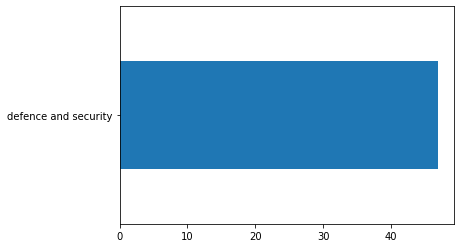

In [ ]:
# Theme 1: defence and security
test_sel_t1_svc = testing_corpus['themes'] == "defence and security"
test_t1_svc = testing_corpus[test_sel_t1_svc]
test_t1_svc.value_counts()
test_t1_svc['predicted_svm'].value_counts().plot.barh()

Theme 2: global health

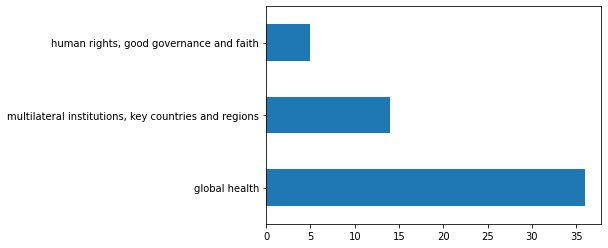

In [ ]:
# Theme 2: global health
test_sel_t2_svc = testing_corpus['themes'] == "global health"
test_t2_svc = testing_corpus[test_sel_t2_svc]
test_t2_svc.value_counts()
test_t2_svc['predicted_svm'].value_counts().plot.barh()

Theme 3: human rights, good governance and faith

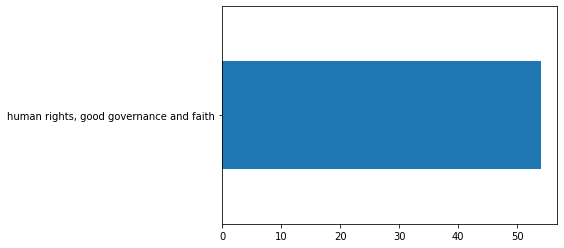

In [ ]:
# Theme 3: human rights, good governance and faith
test_sel_t3_svc = testing_corpus['themes'] == "human rights, good governance and faith"
test_t3_svc = testing_corpus[test_sel_t3_svc]
test_t3_svc.value_counts()
test_t3_svc['predicted_svm'].value_counts().plot.barh()

**Predictions that are different from labeled themes:**

In [ ]:
# Predictions that are different from labeled themes
display(testing_corpus[testing_corpus['themes'] != testing_corpus['predicted_svm']][['raw', 'themes', 'predicted_svm', 'predicted_lr']])

,raw,themes,predicted_svm,predicted_lr
52,proposed dhl program take modular blended lear...,global health,"human rights, good governance and faith","human rights, good governance and faith"
53,leadership development team individual encoura...,global health,"multilateral institutions, key countries and r...","multilateral institutions, key countries and r..."
56,certification including award badging form rec...,global health,"human rights, good governance and faith","human rights, good governance and faith"
62,potential next step commitment interest contin...,global health,"multilateral institutions, key countries and r...","multilateral institutions, key countries and r..."
65,draft strategy go say whilst need vary region ...,global health,"multilateral institutions, key countries and r...","multilateral institutions, key countries and r..."
66,dhl program presented participant wilton park ...,global health,"multilateral institutions, key countries and r...","multilateral institutions, key countries and r..."
73,need competency framework dhl program addition...,global health,"human rights, good governance and faith","human rights, good governance and faith"
74,matter reliable connectivity viability remote ...,global health,"multilateral institutions, key countries and r...","multilateral institutions, key countries and r..."
75,discussion benefit curated coaching session ve...,global health,"multilateral institutions, key countries and r...","multilateral institutions, key countries and r..."
77,leader network community practice typically li...,global health,"human rights, good governance and faith","human rights, good governance and faith"


# 7 | Model III: Logistic Regression - Doc2Vec

The third model we train is logistic regression using `Doc2Vec` as the text vectoriser.

## Tokenisation & Tagging

In [ ]:
# Function to tokenise text
stop_words = set(stopwords.words('english'))

def tokenize_text(text):
  tokens = []
  for sent in nltk.sent_tokenize(text):
    for word in nltk.word_tokenize(sent):
      if (len(word) >= min_characters_word) & (word not in stop_words):
        tokens.append(word)
  return tokens

In [ ]:
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import TaggedDocument

# Splitting into train/test data
train, test = train_test_split(training_corpus, test_size=test_size, random_state=1)

# Tag text with corresponding theme
train_tagged = train.apply(
    lambda r: TaggedDocument(words = tokenize_text(r['text']), tags = [r.themes]), axis = 1)

test_tagged = test.apply(
    lambda r: TaggedDocument(words = tokenize_text(r['text']), tags = [r.themes]), axis = 1)

train_tagged.values[30]

TaggedDocument(words=['afghanistan', 'provides', 'important', 'illustration', 'challenge', 'applying', 'coin', 'strategy', 'context', 'dangerous', 'difficult', 'insurgency', 'attempting', 'build', 'capacity', 'sustainable', 'long', 'term', 'post', 'conflict', 'reconstruction', 'afghan', 'state', 'wake', 'led', 'operation', 'enduring', 'freedom', 'oef', 'autumn', 'important', 'effort', 'made', 'engage', 'international', 'community', 'political', 'economic', 'military', 'term', 'encourage', 'development', 'afghanistan', 'ability', 'govern', 'took', 'place', 'however', 'inadequate', 'resource', 'comprehensiveness', 'pace', 'post', 'conflict', 'reconstruction', 'created', 'condition', 'saw', 'resurgence', 'taliban', 'led', 'insurgency', 'southern', 'region', 'country', 'addition', 'insurgency', 'problem', 'narco', 'criminal', 'culture', 'centred', 'cultivation', 'poppy', 'eradication', 'poppy', 'cultivation', 'issue', 'affecting', 'coin', 'effort', 'state', 'reconstruction', 'consequence',

## Model Training

### Distributed Bag of Words (DBOW)

**Building vocabulary:**

In [ ]:
import multiprocessing
from tqdm import tqdm
from gensim.models import Doc2Vec

cores = multiprocessing.cpu_count()

# Instantiate the model
model_dbow = Doc2Vec(vector_size = 100, window = 5, alpha = .025,
                     min_alpha = 0.00025, min_count = 2, workers = cores)

model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 571/571 [00:00<00:00, 1007550.52it/s]


**Training Doc2Vec - DBOW:**

In [ ]:
import time
import numpy as np
import gensim
from gensim.models import Doc2Vec
from sklearn import utils
tqdm.pandas(desc="progress-bar")

# Max training epochs
max_epochs = 30

# Training doc2vec model
t1 = time.time()
for epoch in range(max_epochs):
  #print('Iteration {0}'.format(epoch + 1))
  model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]),
                   total_examples = len(train_tagged.values), epochs = 1)
  # Decrease the learning rate
  model_dbow.alpha -= 0.002
  # Fix the learning rate, no decay
  model_dbow.min_alpha = model_dbow.alpha

t2 = time.time()
print('Time: {}'.format(t2 - t1))

100%|██████████| 571/571 [00:00<00:00, 1186204.85it/s]


Time: 3.332900047302246


**Vector feature function:**

In [ ]:
def vec_for_learning(model, tagged_docs):
  sents = tagged_docs.values
  targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
  return targets, regressors

**Train the Logistic Regression classifier - DBOW:**

In [ ]:
from sklearn.linear_model import LogisticRegression

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

#logreg_dbow = LogisticRegression(n_jobs = 1, C = 1e5, random_state = 123)
logreg_dbow = LogisticRegression(C = 5, multi_class = 'multinomial', solver = 'saga',
                                 max_iter = 3000, random_state = 1)
logreg_dbow.fit(X_train, y_train)

y_pred = logreg_dbow.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.7692307692307693
Testing F1 score: 0.7761063888959694


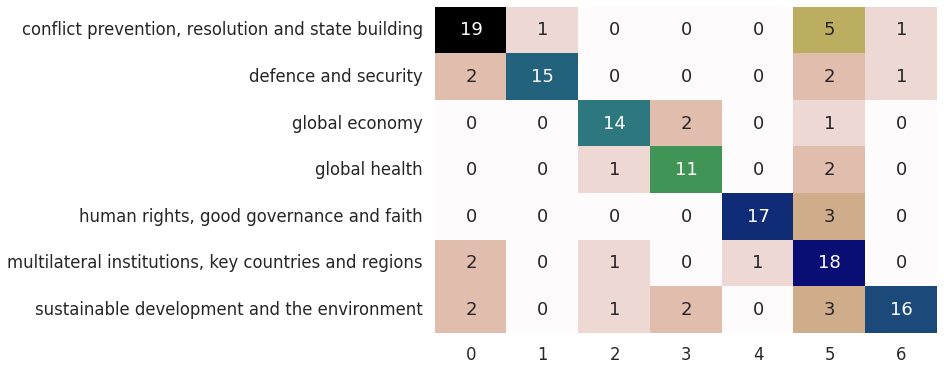



                                                      precision    recall  f1-score   support

  conflict prevention, resolution and state building       0.76      0.73      0.75        26
                                defence and security       0.94      0.75      0.83        20
                                      global economy       0.82      0.82      0.82        17
                                       global health       0.73      0.79      0.76        14
             human rights, good governance and faith       0.94      0.85      0.89        20
multilateral institutions, key countries and regions       0.53      0.82      0.64        22
         sustainable development and the environment       0.89      0.67      0.76        24

                                            accuracy                           0.77       143
                                           macro avg       0.80      0.77      0.78       143
                                        weighted avg    

In [ ]:
heatconmat(pd.Series(y_test), y_pred)

### Distributed Memory (DM)

**Building vocabulary:**

In [ ]:
# Building vocabulary
model_dmm = Doc2Vec(vector_size = 100, window = 5, alpha = .025,
                    min_alpha = 0.00025, min_count = 2, dm = 1, workers = cores)

model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 571/571 [00:00<00:00, 1048117.10it/s]


**Training Doc2Vec - DM:**

In [ ]:
# Training doc2vec model
%%time
for epoch in range(30):
  model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]),
                  total_examples = len(train_tagged.values), epochs = 1)
  # Decrease the learning rate
  model_dmm.alpha -= 0.002
  # Fix the learning rate, no decay
  model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 571/571 [00:00<00:00, 1589215.38it/s]


CPU times: user 4.46 s, sys: 251 ms, total: 4.72 s
Wall time: 3.32 s


**Train the Logistic Regression classifier - DM:**

In [ ]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

#logreg_dmm = LogisticRegression(n_jobs = 1, C = 1e5, random_state = 123)
logreg_dmm = LogisticRegression(C = 5, multi_class = 'multinomial', solver = 'saga',
                                max_iter = 3000, random_state = 123)
logreg_dmm.fit(X_train, y_train)

y_pred = logreg_dmm.predict(X_test)

In [ ]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.7832167832167832
Testing F1 score: 0.7824867753007361


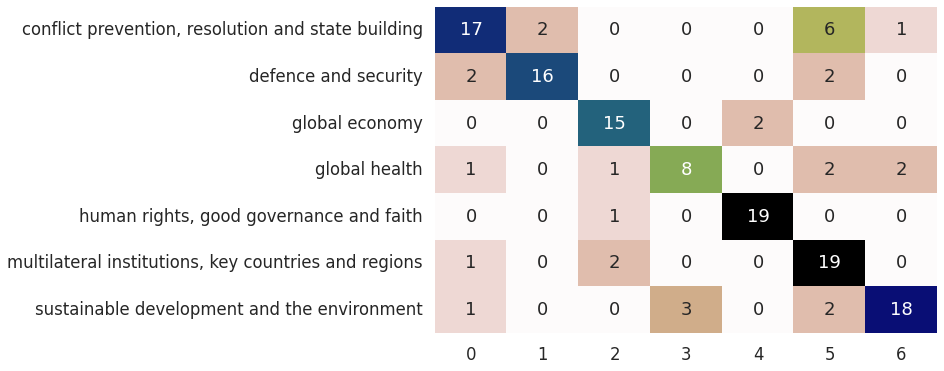



                                                      precision    recall  f1-score   support

  conflict prevention, resolution and state building       0.77      0.65      0.71        26
                                defence and security       0.89      0.80      0.84        20
                                      global economy       0.79      0.88      0.83        17
                                       global health       0.73      0.57      0.64        14
             human rights, good governance and faith       0.90      0.95      0.93        20
multilateral institutions, key countries and regions       0.61      0.86      0.72        22
         sustainable development and the environment       0.86      0.75      0.80        24

                                            accuracy                           0.78       143
                                           macro avg       0.79      0.78      0.78       143
                                        weighted avg    

In [ ]:
heatconmat(pd.Series(y_test), y_pred)

### Combined Model Pairing

**Concatenated Doc2Vec (DBOW & DM):**

In [ ]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

# Concatenate the two models
model_new = ConcatenatedDoc2Vec([model_dbow, model_dmm])

**Vector feature function:**

In [ ]:
# Building feature vectors
def get_vectors(model, tagged_docs):
  sents = tagged_docs.values
  targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
  return targets, regressors

**Train the Logistic Regression Classifier - Combined model pairing:**

In [ ]:
# Training the Logistic Regression
y_train, X_train = get_vectors(model_new, train_tagged)
y_test, X_test = get_vectors(model_new, test_tagged)
logreg_new = LogisticRegression(C = 5, multi_class = 'multinomial', solver = 'saga',
                                max_iter = 3000, random_state = 1)
logreg_new.fit(X_train, y_train)
y_pred = logreg_new.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [ ]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.8041958041958042
Testing F1 score: 0.8138784538912966


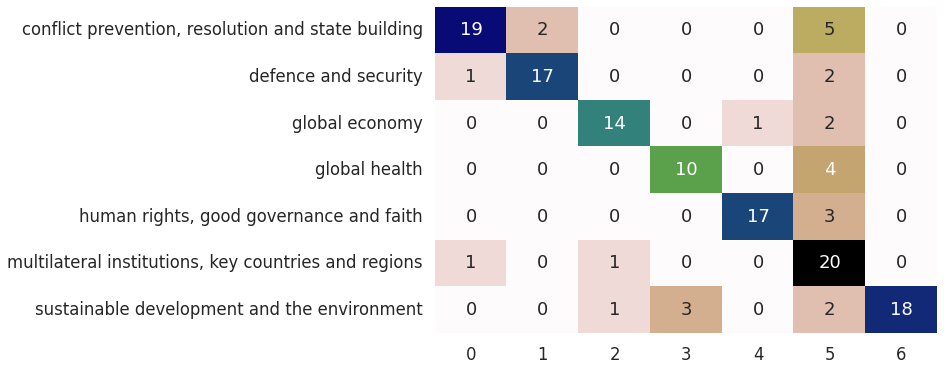



                                                      precision    recall  f1-score   support

  conflict prevention, resolution and state building       0.90      0.73      0.81        26
                                defence and security       0.89      0.85      0.87        20
                                      global economy       0.88      0.82      0.85        17
                                       global health       0.77      0.71      0.74        14
             human rights, good governance and faith       0.94      0.85      0.89        20
multilateral institutions, key countries and regions       0.53      0.91      0.67        22
         sustainable development and the environment       1.00      0.75      0.86        24

                                            accuracy                           0.80       143
                                           macro avg       0.84      0.80      0.81       143
                                        weighted avg    

In [ ]:
heatconmat(pd.Series(y_test), y_pred)

In [ ]:
# Saving the model using joblib
filename_m3 = "gdrive/MyDrive/Colab Notebooks/models/v1.3-wilton/output/lr_doc2vec_model.sav"  
joblib.dump(logreg_new, filename_m3)

['gdrive/MyDrive/Colab Notebooks/models/v1.3-wilton/output/lr_doc2vec_model.sav']

## Model Evaluation

To better understand the model, we visualise the distribution of prediction for each themes.

**Distribution of prediction for each theme:**

In [ ]:
# Class names from the prediction
class_names = list(logreg_new.classes_)

# Create training result dataframe
train_y_pred = pd.DataFrame(y_pred, columns = ['prediction'])
train_x_test = pd.DataFrame(test_tagged, columns = ['text'])
train_y_test = pd.DataFrame(y_test, columns = ['themes'])

train_idx = train_x_test.index # Preserve index
train_x_test.reset_index(drop=True, inplace=True) # Reset index to concat
train_y_test.reset_index(drop=True, inplace=True)

# Retrieve raw text
raw_d2v = []

for i in train_idx:
  raw_d2v.append(training_corpus.iloc[i]['raw'])

train_raw = pd.DataFrame(raw_d2v, columns = ['raw'])['raw'].apply(removeNewLine)

# Concat all columns
train_result_d2v = pd.concat([train_raw, train_y_test, train_y_pred], axis = 1)
train_result_d2v = train_result_d2v.set_index(train_idx)
#train_result_d2v.head()

Theme 1: conflict prevention, resolution and state building

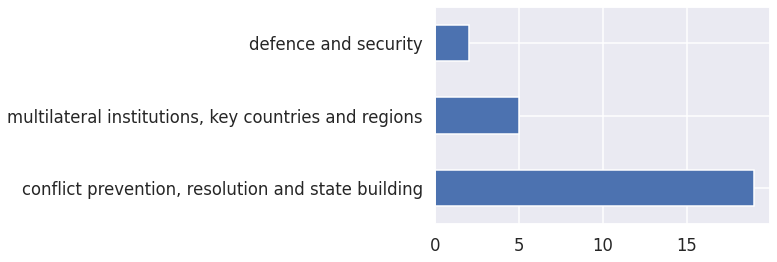

In [ ]:
# Theme 1: conflict prevention, resolution and state building
train_sel_t1 = train_result_d2v['themes'] == "conflict prevention, resolution and state building"
train_t1 = train_result_d2v[train_sel_t1]
train_t1.value_counts()
train_t1['prediction'].value_counts().plot.barh()

Theme 2: defence and security

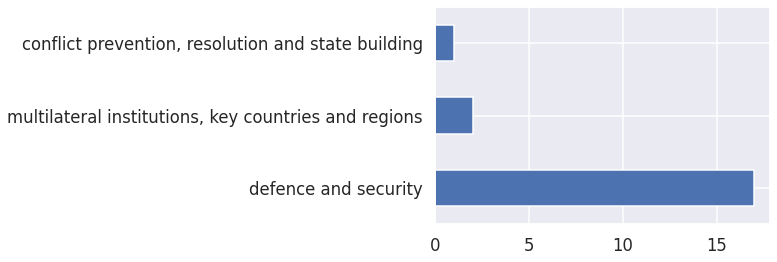

In [ ]:
# Theme 2: defence and security
train_sel_t2 = train_result_d2v['themes'] == "defence and security"
train_t2 = train_result_d2v[train_sel_t2]
train_t2.value_counts()
train_t2['prediction'].value_counts().plot.barh()

Theme 3: global economy

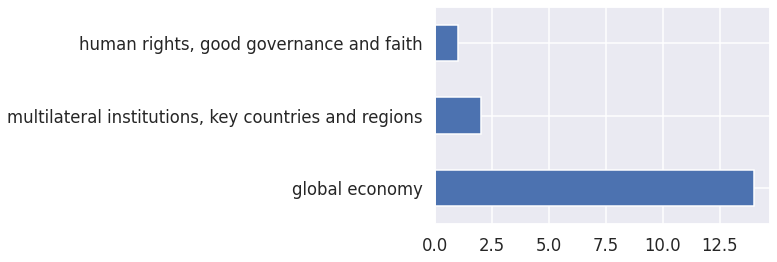

In [ ]:
# Theme 3: global economy
train_sel_t3 = train_result_d2v['themes'] == "global economy"
train_t3 = train_result_d2v[train_sel_t3]
train_t3.value_counts()
train_t3['prediction'].value_counts().plot.barh()

Theme 4: global health

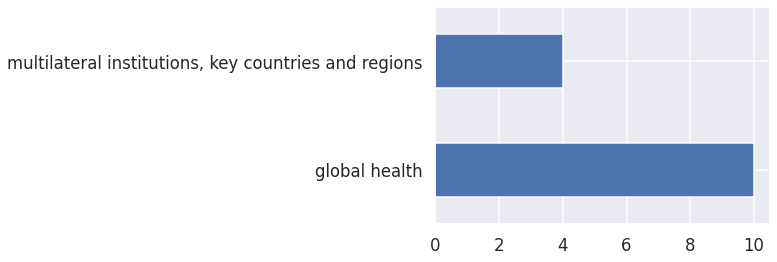

In [ ]:
# Theme 4: global health
train_sel_t4 = train_result_d2v['themes'] == "global health"
train_t4 = train_result_d2v[train_sel_t4]
train_t4.value_counts()
train_t4['prediction'].value_counts().plot.barh()

Theme 5: human rights, good governance and faith

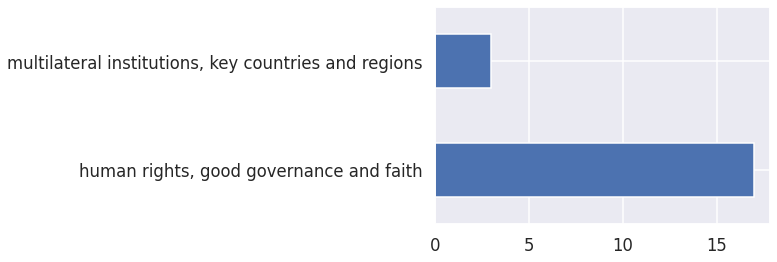

In [ ]:
# Theme 5: human rights, good governance and faith
train_sel_t5 = train_result_d2v['themes'] == "human rights, good governance and faith"
train_t5 = train_result_d2v[train_sel_t5]
train_t5.value_counts()
train_t5['prediction'].value_counts().plot.barh()

Theme 6: multilateral institutions, key countries and regions

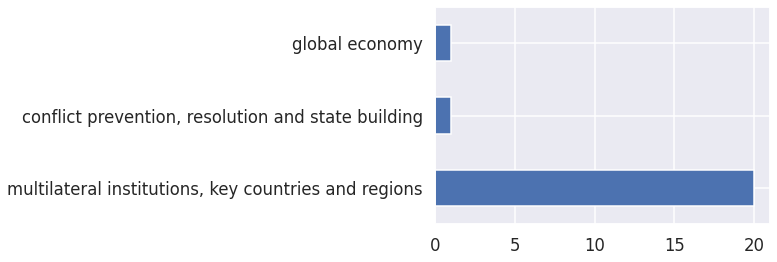

In [ ]:
# Theme 6: multilateral institutions, key countries and regions
train_sel_t6 = train_result_d2v['themes'] == "multilateral institutions, key countries and regions"
train_t6 = train_result_d2v[train_sel_t6]
train_t6.value_counts()
train_t6['prediction'].value_counts().plot.barh()

Theme 7: sustainable development and the environment

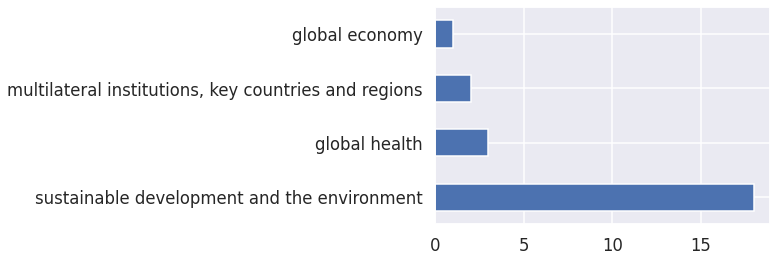

In [ ]:
# Theme 7: sustainable development and the environment
train_sel_t7 = train_result_d2v['themes'] == "sustainable development and the environment"
train_t7 = train_result_d2v[train_sel_t7]
train_t7.value_counts()
train_t7['prediction'].value_counts().plot.barh()

**Predictions that are different from labeled themes:**

In [ ]:
# Predictions that are different from labeled themes
train_d2v_false_pred = train_result_d2v[train_result_d2v.themes != train_result_d2v.prediction]
display(train_d2v_false_pred)

,raw,themes,prediction
546,59. The best way to deal with regional concer...,"multilateral institutions, key countries and r...","conflict prevention, resolution and state buil..."
223,• Political leadership: what needs to be quali...,global economy,"multilateral institutions, key countries and r..."
377,"38. For healthy societies, a crucial question...",global health,"multilateral institutions, key countries and r..."
69,13. Political appetite for preventative actio...,"conflict prevention, resolution and state buil...",defence and security
441,41. The WHO’s RESPECT initiative11 provides a...,"human rights, good governance and faith","multilateral institutions, key countries and r..."
396,60. It is important for the research agenda t...,global health,"multilateral institutions, key countries and r..."
453,This Wilton Park meeting was acknowledged as a...,"human rights, good governance and faith","multilateral institutions, key countries and r..."
60,4. These economic and demographic trends will...,"conflict prevention, resolution and state buil...","multilateral institutions, key countries and r..."
117,16. Despite NATO’s effort to renew its nuclea...,defence and security,"conflict prevention, resolution and state buil..."
341,Reports reflect rapporteurs’ accounts of the p...,global health,"multilateral institutions, key countries and r..."


# 8 | Prediction on Ditchley Archive

## Load Ditchley Archive from GDrive

In [ ]:
# Setting dir path
dir_ditchley = "gdrive/MyDrive/Digital Archive - Director's Notes/Digital Archive - Director's Notes/1990s/"

# Extract filenames and filter only docx
df_ditchley = extractFilenames(dir_ditchley)
df_ditchley = df_ditchley[(df_ditchley.file_names.str.endswith('.docx')) & ~(df_ditchley.file_names.str.startswith('~'))].reset_index(drop=True)

# Get archive from the year of 1990
df_ditchley90 = df_ditchley[df_ditchley.folder_names == '1990']

# Extract training corpus
ditchley_text = extractText(df_ditchley90)

## Pre-processing

In [ ]:
# Remove rows containing participants list
title = ['Mr ', 'Sir ', 'Professor ', 'Dr ', 'Ms ', 'Mrs ', 'Ambassador ', 'HE ']

ditchley_text = ditchley_text[~(np.array([any(j in text for j in title) for text in ditchley_text.text]))]
ditchley_text.shape

(704, 3)

In [ ]:
# Preserve raw text
ditchley_text['raw'] = ditchley_text['text']

# Rename column names
ditchley_text.rename(columns={"folder_names": "year"}, inplace=True)

# Apply text cleaning
ditchley_text['text'] = ditchley_text['text'].apply(cleanText)

ditchley_text.head()

,text,year,filenames,raw
0,agenda broad everybody agreed impossible gener...,1990,90 01 v2.docx,Our agenda was broad. Everybody agreed that it...
1,since nkrumah dictum seek first political king...,1990,90 01 v2.docx,"Since Nkrumah's dictum, ""Seek ye first the pol..."
2,agreed african outsider prescribe remedy howev...,1990,90 01 v2.docx,"All agreed that it was for Africans, not for o..."
3,channelling aid important consult government p...,1990,90 01 v2.docx,"In channelling aid, it was important to consul..."
4,debt though absolutely large constituted cripp...,1990,90 01 v2.docx,"Debt, though not absolutely large, constituted..."


## Prediction Result

In [ ]:
# Model prediction
y_pred_ditchley = svc_cal.predict(tf_transformer.transform(count_vect.transform(ditchley_text['text'])))

# Display prediction result
ditchley_text['predicted_theme'] = y_pred_ditchley

display(ditchley_text[['raw', 'year', 'predicted_theme', 'filenames']])

,raw,year,predicted_theme,filenames
0,Our agenda was broad. Everybody agreed that it...,1990,"conflict prevention, resolution and state buil...",90 01 v2.docx
1,"Since Nkrumah's dictum, ""Seek ye first the pol...",1990,"multilateral institutions, key countries and r...",90 01 v2.docx
2,"All agreed that it was for Africans, not for o...",1990,"conflict prevention, resolution and state buil...",90 01 v2.docx
3,"In channelling aid, it was important to consul...",1990,global health,90 01 v2.docx
4,"Debt, though not absolutely large, constituted...",1990,global health,90 01 v2.docx
...,...,...,...,...
946,Global (as distinct from regional or US-Soviet...,1990,"conflict prevention, resolution and state buil...",90 15 v2.docx
947,"Formal agreed controls over arms sales, and mi...",1990,"multilateral institutions, key countries and r...",90 15 v2.docx
948,Many subjects were felt by most participants t...,1990,"multilateral institutions, key countries and r...",90 15 v2.docx
949,The subject of security does not lend itself t...,1990,defence and security,90 15 v2.docx


## Theme Distribution

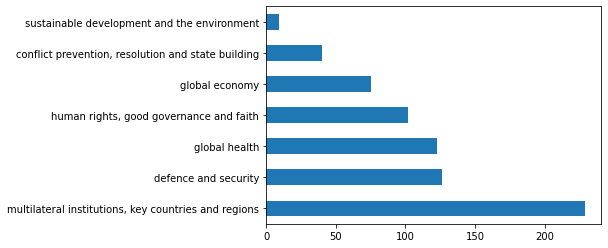

In [ ]:
# Theme distribution
ditchley_text['predicted_theme'].value_counts().plot.barh()

End of notebook

In [2]:
print("Congratulations!")

Congratulations!
